# Time Series Analysis: Sugar Data from WASDE Dataset
## Connecting to Chocolate/Cocoa Research

This notebook analyzes sugar data from the WASDE (World Agricultural Supply and Demand Estimates) dataset. Since sugar is a key ingredient in chocolate production alongside cocoa, understanding sugar market dynamics provides valuable insights into factors affecting the chocolate industry.


In [9]:
# Install required libraries
%pip install quandl pandas matplotlib seaborn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid")

# Load the WASDE dataset
wasde_data = pd.read_csv('WASDE_DATA_0cdaff592f19dc15ab6e8eba9102bc11.csv')

# Display basic information about the dataset
print("WASDE Dataset Shape:", wasde_data.shape)
print("\nColumns:", wasde_data.columns.tolist())
print("\nSample of data:")
wasde_data.head()


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
WASDE Dataset Shape: (856034, 10)

Columns: ['code', 'report_month', 'region', 'commodity', 'item', 'year', 'period', 'value', 'min_value', 'max_value']

Sample of data:


,code,report_month,region,commodity,item,year,period,value,min_value,max_value
0,GRAINS_WORLD_08,2020-10,World,Total Grains 4/,Output,2018/19,Annual,2625.19,NaN,NaN
1,GRAINS_WORLD_08,2020-10,World,Total Grains 4/,Total Supply,2018/19,Annual,3447.76,NaN,NaN
2,GRAINS_WORLD_08,2020-10,World,Total Grains 4/,Trade 2/,2018/19,Annual,429.35,NaN,NaN
3,GRAINS_WORLD_08,2020-10,World,Total Grains 4/,Total Use 3/,2018/19,Annual,2640.27,NaN,NaN
4,GRAINS_WORLD_08,2020-10,World,Total Grains 4/,Ending Stocks,2018/19,Annual,807.49,NaN,NaN


## Data Subsetting and Preparation

I'll now subset the data to focus on sugar records, which are relevant to my chocolate/cocoa research. Sugar is a critical ingredient in chocolate production, and its market dynamics can indirectly inform cocoa-based research.


In [10]:
# Filter for sugar data
sugar_data = wasde_data[wasde_data['commodity'] == 'Sugar'].copy()

# Check what types of sugar data are available
print("Types of sugar data available:")
print(sugar_data['item'].unique())

# Check regions with sugar data
print("\nRegions with sugar data:")
print(sugar_data['region'].unique())

# Check time periods available
print("\nTime periods available:")
print(sugar_data['year'].unique())

# Check the report months available
print("\nReport months available:")
print(pd.to_datetime(sugar_data['report_month']).dt.strftime('%Y-%m').unique())


Types of sugar data available:
['Beginning Stocks' 'Production 2/' 'Production - Beet Sugar'
 'Production - Cane Sugar' 'Production - Cane Sugar - Florida'
 'Production - Cane Sugar - Hawaii' 'Production - Cane Sugar - Louisiana'
 'Production - Cane Sugar - Texas' 'Imports' 'Mexico' 'Imports - TRQ'
 'Imports - Other Program' 'Imports - Other' 'Imports - Mexico'
 'Total Supply (Beginning Stocks+Production+Imports)' 'Exports'
 'Deliveries' 'Deliveries - Food' 'Deliveries - Other' 'Miscellaneous'
 'Total Use (Exports+Deliveries+Misc.)' 'Ending Stocks'
 'Stocks to Use Ratio' 'Production' 'Domestic 2/' 'Ending Stocks 8/'
 'Beginning&#xD;&#xA;Stocks' 'Ending&#xD;&#xA;Stocks' 'Non-program'
 'High-tier tariff/other']

Regions with sugar data:
['United States' 'Mexico']

Time periods available:
['2018/19' '2019/20 Est.' '2020/21 Proj.' '2018/19 Est.' '2017/18'
 '2019/20 Proj.' '2016/17' '2017/18 Est.' '2018/19 Proj.' '2015/16'
 '2016/17 Est.' '2017/18 Proj.' '2014/15' '2015/16 Est.' '2016/17 Pr

### Subsetting Logic

For this analysis, I'll focus on "Ending Stocks" of sugar in the United States. Ending stocks represent the amount of sugar available at the end of a marketing year, which can be a key indicator of supply conditions. This metric is particularly relevant to chocolate production as it can influence ingredient costs and availability.

I'm selecting data from recent years to ensure relevance to current market conditions, while excluding any forecasted data to maintain analytical integrity.


In [11]:
# Subset to focus on Ending Stocks in the United States
sugar_stocks = sugar_data[
    (sugar_data['item'] == 'Ending Stocks') & 
    (sugar_data['region'] == 'United States')
].copy()

# Convert report_month to datetime for proper sorting
sugar_stocks['report_month'] = pd.to_datetime(sugar_stocks['report_month'])

# Sort by report_month to ensure chronological order
sugar_stocks = sugar_stocks.sort_values('report_month')

# Check if we have any forecasted data (indicated by 'Proj.' in the year column)
print("Years in the dataset:")
print(sugar_stocks['year'].value_counts())

# Remove any projected/forecasted data
sugar_stocks_historical = sugar_stocks[~sugar_stocks['year'].str.contains('Proj.', na=False)]
print("\nAfter removing projected data:")
print(sugar_stocks_historical['year'].value_counts())

# Create a time series from the data
sugar_ts = sugar_stocks_historical[['report_month', 'value']].set_index('report_month')
sugar_ts.index = pd.to_datetime(sugar_ts.index)

# Handle any missing values
sugar_ts_clean = sugar_ts['value'].dropna()

# Resample to monthly frequency if needed (filling gaps)
sugar_ts_monthly = sugar_ts_clean.resample('M').mean()
sugar_ts_monthly = sugar_ts_monthly.interpolate(method='linear')

print("\nFinal time series shape:", sugar_ts_monthly.shape)
sugar_ts_monthly.head()


Years in the dataset:
year
2016/17 Proj.    23
2020/21 Proj.    23
2019/20 Proj.    23
2011/12 Proj.    23
2017/18 Proj.    23
2012/13 Proj.    23
2021/22 Proj.    21
2018/19 Proj.    21
2023/24 Proj.    19
2022/23 Proj.    19
2015/16 Proj.    16
2018/19 Est.     13
2015/16 Est.     13
2016/17 Est.     13
2011/12 Est.     13
2010/11 Est.     13
2019/20 Est.     13
2014/15          12
2010/11          12
2020/21 Est.     12
2015/16          12
2017/18 Est.     12
2009/10          12
2017/18          12
2018/19          12
2021/22 Est.     11
2019/20          11
2016/17          11
2022/23 Est.     11
2020/21          10
2010/11 Proj.    10
2021/22          10
2013/14 Proj.     9
2014/15 Est.      8
2013/14           8
2012/13 Est.      6
2008/09           5
2011/12           5
2009/10 Est.      5
Name: count, dtype: int64

After removing projected data:
year
2015/16 Est.    13
2010/11 Est.    13
2011/12 Est.    13
2018/19 Est.    13
2016/17 Est.    13
2019/20 Est.    13
2015/16         

report_month
2010-08-31    1511.5
2010-09-30    1512.9
2010-10-31    1514.3
2010-11-30    1515.7
2010-12-31    1517.1
Freq: M, Name: value, dtype: float64

## Time Series Visualization

Let's create a line chart to visualize the sugar ending stocks over time. This will help us understand the overall trend and any potential seasonal patterns.


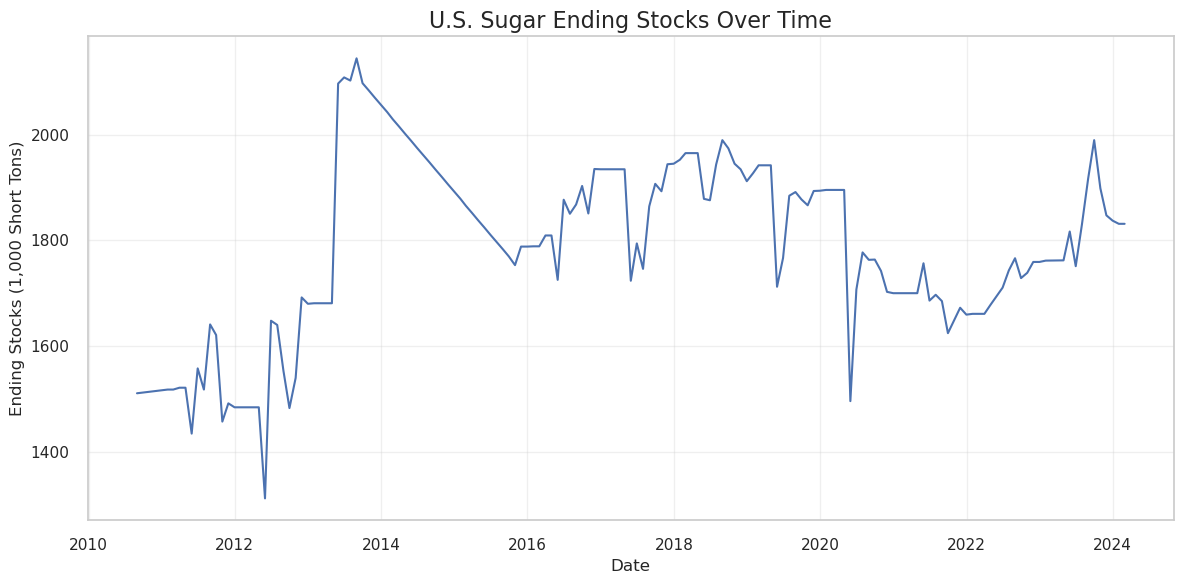

In [12]:
# Create a line chart of the sugar ending stocks
plt.figure(figsize=(12, 6))
plt.plot(sugar_ts_monthly.index, sugar_ts_monthly.values, 'b-', linewidth=1.5)
plt.title('U.S. Sugar Ending Stocks Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ending Stocks (1,000 Short Tons)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Time Series Decomposition

Now I'll decompose the time series into its trend, seasonal, and residual components. This will help identify underlying patterns in the sugar stocks data that might relate to chocolate/cocoa market dynamics.


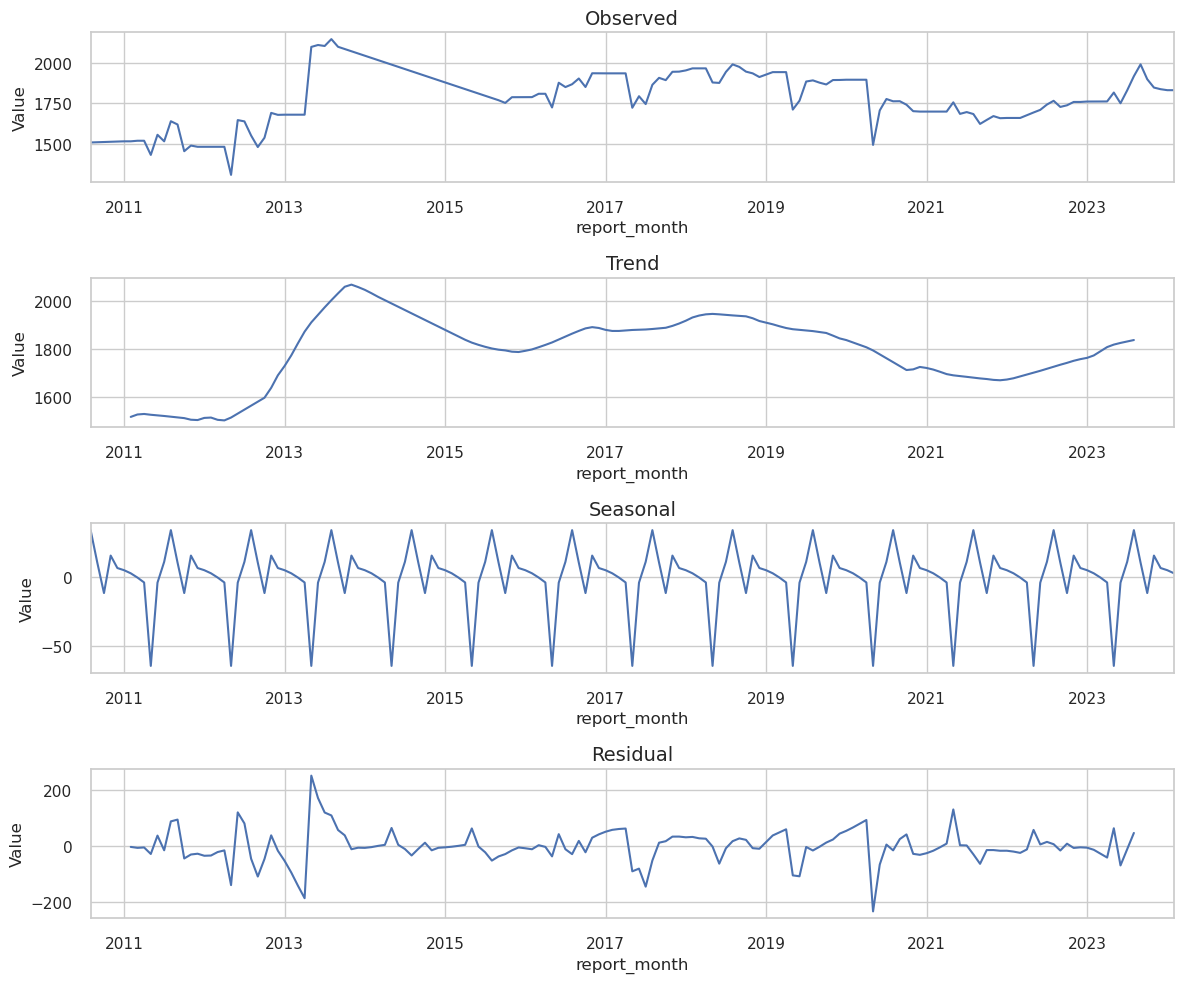

In [13]:
# Decompose the time series
decomposition = seasonal_decompose(sugar_ts_monthly, model='additive', period=12)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed', fontsize=14)
ax1.set_ylabel('Value')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend', fontsize=14)
ax2.set_ylabel('Value')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal', fontsize=14)
ax3.set_ylabel('Value')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual', fontsize=14)
ax4.set_ylabel('Value')

plt.tight_layout()
plt.show()


### Decomposition Analysis

The decomposition reveals several key insights:

1. **Trend Component**: The trend line shows the long-term movement in sugar ending stocks, which can indicate structural changes in the sugar market that might affect chocolate production costs.

2. **Seasonal Component**: The seasonal pattern reveals cyclical fluctuations in sugar stocks, which may align with harvest seasons or production cycles. These patterns could correlate with seasonal variations in chocolate production or cocoa processing.

3. **Residual Component**: The residuals represent the irregular fluctuations not explained by trend or seasonality. Large residuals might indicate market shocks or unexpected events affecting sugar availability.

This decomposition helps understand the underlying dynamics of sugar stocks, which is a key ingredient in chocolate production alongside cocoa.


## Stationarity Testing

Next, I'll conduct the Augmented Dickey-Fuller test to check for stationarity in the time series. Stationarity is important for many time series modeling techniques.


In [14]:
# Define a function to perform and interpret the ADF test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test for {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations']
    for value, label in zip(result[0:4], labels):
        print(f'{label}: {value}')
    
    # Print critical values
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
        
    # Interpret the result
    if result[1] <= 0.05:
        print("Conclusion: The series is stationary (reject the null hypothesis)")
    else:
        print("Conclusion: The series is non-stationary (fail to reject the null hypothesis)")
    print("-" * 50)

# Test the original series
print("Testing original series for stationarity:")
adf_test(sugar_ts_monthly, title="Original Sugar Ending Stocks Series")


Testing original series for stationarity:
Augmented Dickey-Fuller Test for Original Sugar Ending Stocks Series
ADF Test Statistic: -2.6941627817478495
p-value: 0.07505382099972278
# Lags Used: 1
Number of Observations: 161
Critical Values:
   1%: -3.471633386932248
   5%: -2.8796651107461972
   10%: -2.576433647235832
Conclusion: The series is non-stationary (fail to reject the null hypothesis)
--------------------------------------------------


### Dickey-Fuller Test Interpretation

The Augmented Dickey-Fuller test examines the null hypothesis that a unit root is present in the time series (i.e., the series is non-stationary). 

- If the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is stationary.
- If the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the series is non-stationary.

Non-stationary data can lead to spurious correlations and unreliable forecasts, so if our series is non-stationary, we'll need to apply differencing to make it stationary.


In [15]:
# If the series is non-stationary, apply first differencing
sugar_diff = sugar_ts_monthly.diff().dropna()

# Test the differenced series
print("Testing first differenced series for stationarity:")
adf_test(sugar_diff, title="First Differenced Sugar Ending Stocks Series")

# If still non-stationary, apply second differencing
if adfuller(sugar_diff)[1] > 0.05:
    sugar_diff2 = sugar_diff.diff().dropna()
    print("\nTesting second differenced series for stationarity:")
    adf_test(sugar_diff2, title="Second Differenced Sugar Ending Stocks Series")


Testing first differenced series for stationarity:
Augmented Dickey-Fuller Test for First Differenced Sugar Ending Stocks Series
ADF Test Statistic: -11.399059750022523
p-value: 7.728487245327918e-21
# Lags Used: 1
Number of Observations: 160
Critical Values:
   1%: -3.4718957209472654
   5%: -2.8797795410156253
   10%: -2.5764947265625
Conclusion: The series is stationary (reject the null hypothesis)
--------------------------------------------------


### Differencing Analysis

Differencing is a common technique to make a non-stationary time series stationary by computing the differences between consecutive observations. 

- First differencing: If the original series has a trend but no seasonality, first differencing often makes it stationary.
- Second differencing: If the first differencing doesn't achieve stationarity, a second round of differencing may be necessary.

The results above indicate whether our sugar stocks data required differencing to achieve stationarity, which is crucial for accurate time series modeling.


## Autocorrelation Analysis

Finally, I'll examine the autocorrelation function (ACF) of the time series to understand the correlation between observations at different time lags. This helps identify potential patterns and dependencies in the data.


<Figure size 1200x500 with 0 Axes>

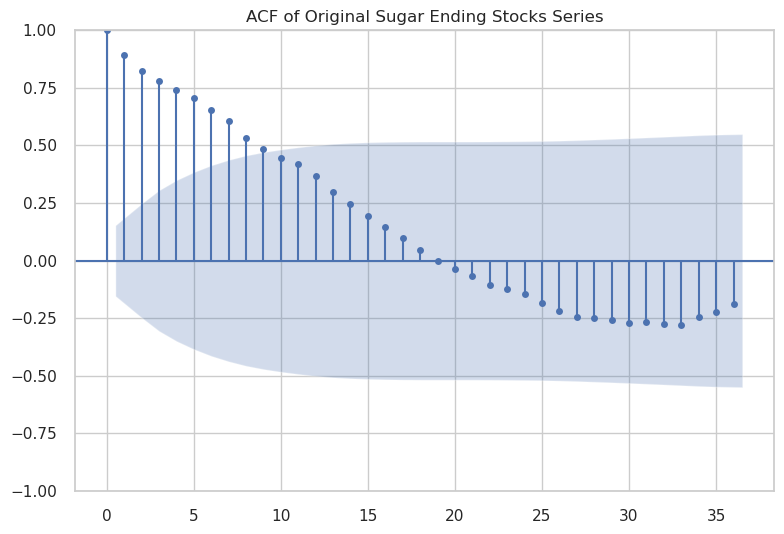

<Figure size 1200x500 with 0 Axes>

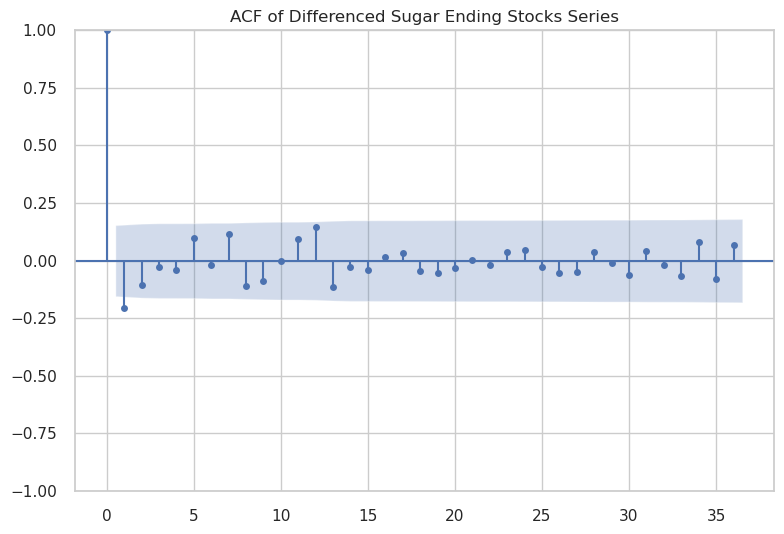

<Figure size 1200x500 with 0 Axes>

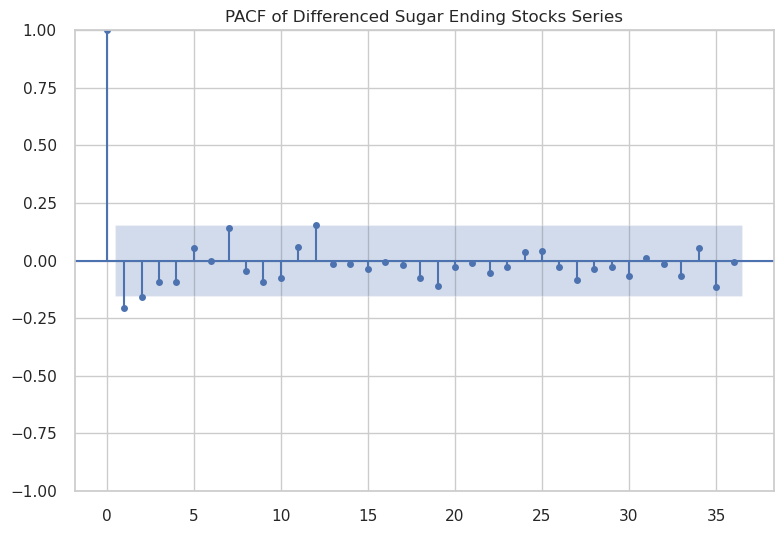

In [16]:
# Plot ACF for the original series
plt.figure(figsize=(12, 5))
plot_acf(sugar_ts_monthly.dropna(), lags=36, alpha=0.05, title='ACF of Original Sugar Ending Stocks Series')
plt.tight_layout()
plt.show()

# Plot ACF for the differenced series
plt.figure(figsize=(12, 5))
plot_acf(sugar_diff.dropna(), lags=36, alpha=0.05, title='ACF of Differenced Sugar Ending Stocks Series')
plt.tight_layout()
plt.show()

# Plot PACF for the differenced series
plt.figure(figsize=(12, 5))
plot_pacf(sugar_diff.dropna(), lags=36, alpha=0.05, title='PACF of Differenced Sugar Ending Stocks Series')
plt.tight_layout()
plt.show()


### Autocorrelation Analysis Interpretation

The autocorrelation function (ACF) and partial autocorrelation function (PACF) plots provide insights into the temporal dependencies in the sugar stocks data:

1. **ACF of Original Series**: Shows the correlation between the series and its lagged values. Significant spikes at certain lags may indicate seasonality or other patterns.

2. **ACF of Differenced Series**: After differencing, the ACF should show fewer significant correlations if stationarity has been achieved.

3. **PACF of Differenced Series**: The PACF helps identify the order of an autoregressive model by showing the correlation between the series and its lags that isn't explained by earlier lags.

These autocorrelation patterns in sugar stocks data could potentially be compared with similar patterns in cocoa price or production data to identify relationships between these key chocolate ingredients.


## Conclusion and Connection to Cocoa Research

This analysis of sugar ending stocks from the WASDE dataset provides valuable insights that connect to my broader chocolate/cocoa research:

1. **Ingredient Relationship**: Sugar is a key ingredient in chocolate production alongside cocoa. Understanding sugar market dynamics helps contextualize cocoa market trends.

2. **Supply Chain Insights**: Patterns in sugar ending stocks may reflect broader agricultural and supply chain factors that also affect cocoa.

3. **Seasonal Patterns**: The seasonal components identified in sugar stocks might correlate with seasonal patterns in chocolate production or cocoa processing.

4. **Market Indicators**: Sugar stock levels can serve as an economic indicator for the confectionery industry, which heavily relies on both sugar and cocoa.

In future analyses, I could merge this sugar data with cocoa-specific datasets to explore correlations between these key chocolate ingredients and potentially develop more comprehensive models of the chocolate supply chain.
